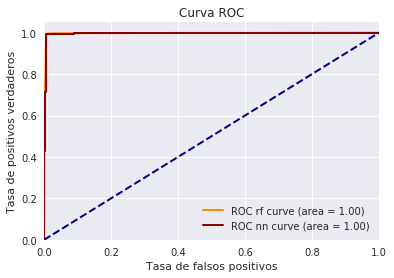

None


In [14]:
# Importamos las librerias a usar en python
import feather
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.externals import joblib
from sklearn.metrics import roc_curve, auc
import itertools

# Importamos los odatso de pruebaPrueba
prueba = feather.read_dataframe("datos/prueba.feather")
X_prueba = prueba.drop('Occupancy', axis = 1)
y_prueba = prueba['Occupancy']

# Importamos los modelos para el análisis
rf_final = joblib.load('modelos/rf_final.pkl')
nn_final = joblib.load('modelos/nn_final.pkl')

# Se calculan las probabilidades de cada modelo
rf_y_probas = rf_final.predict_proba(X_prueba)
nn_y_probas = nn_final.predict_proba(X_prueba)

y_prueba = np.array(pd.DataFrame([1-pd.to_numeric(y_prueba), pd.to_numeric(y_prueba)]).transpose())
rf_fpr = dict()
rf_tpr = dict()
rf_roc_auc = dict()
for i in range(2):
    rf_fpr[i], rf_tpr[i], _ = roc_curve(y_prueba[:, i], rf_y_probas[:, i])
    rf_roc_auc[i] = auc(rf_fpr[i], rf_tpr[i])

nn_fpr = dict()
nn_tpr = dict()
nn_roc_auc = dict()
for i in range(2):
    nn_fpr[i], nn_tpr[i], _ = roc_curve(y_prueba[:, i], nn_y_probas[:, i])
    nn_roc_auc[i] = auc(nn_fpr[i], nn_tpr[i])

# Se grafica la curva ROC para ambos modelos
plt.figure()
lw = 2
plt.plot(rf_fpr[1], rf_tpr[1], color='darkorange',
         lw=lw, label='ROC rf curve (area = %0.2f)' % rf_roc_auc[1])
plt.plot(nn_fpr[1], nn_tpr[1], color='darkred',
         lw=lw, label='ROC nn curve (area = %0.2f)' % nn_roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de positivos verdaderos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
print(plt.show())

# En este caso la cura ROC no nos permite observar una clara diferencia enre ambos modelos. Por tal motivo se graficará
# Alrededor del (1,1) para tratar de disernir diferencias entre lso modelos.
# (nota: el áre bajo la curva es 1.00 pero esto se debe al redondeo ya que en las matrices de confusión si se observaron
# falsos positivos y negativos


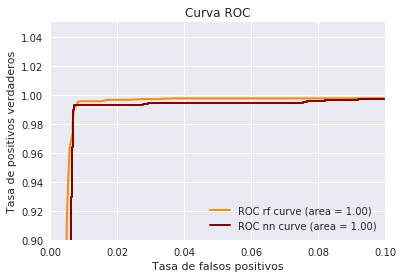

None


In [15]:
# Se grafica la curva ROC para ambos modelos
plt.figure()
lw = 2
plt.plot(rf_fpr[1], rf_tpr[1], color='darkorange',
         lw=lw, label='ROC rf curve (area = %0.2f)' % rf_roc_auc[1])
plt.plot(nn_fpr[1], nn_tpr[1], color='darkred',
         lw=lw, label='ROC nn curve (area = %0.2f)' % nn_roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 0.1])
plt.ylim([0.9, 1.05])
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de positivos verdaderos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
print(plt.show())

# Al hacer un "zoom" a la curva se observan diferencias en el comportamiento de las curvas ROC.
# Por ejemplo, el modelo de bosques aleatorios es mejor para puntos de cortemenores a 0.01 (aprox) o mayores a 0.015 (aprox)
# Mientras que, el modelo de redes neuronales tiene un mejor desempeño para puntos de corte entre 0.01 y 0.15
# Para puntos de corte mayores o iguales a 0.08 se obseva que ambos modelos tienen el mismo desempeño.

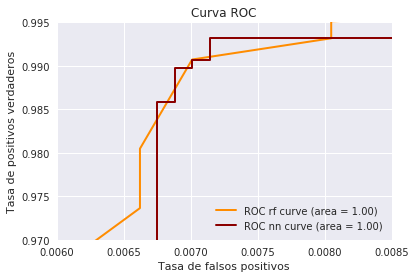

None


In [17]:
# Se grafica la curva ROC para ambos modelos
plt.figure()
lw = 2
plt.plot(rf_fpr[1], rf_tpr[1], color='darkorange',
         lw=lw, label='ROC rf curve (area = %0.2f)' % rf_roc_auc[1])
plt.plot(nn_fpr[1], nn_tpr[1], color='darkred',
         lw=lw, label='ROC nn curve (area = %0.2f)' % nn_roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.006, 0.0085])
plt.ylim([0.97, 0.995])
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de positivos verdaderos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
print(plt.show())

# Haciendo un "zoom" mayor al intervalo donde la curva del modelo de redes neuronales está por arriba de la curva del
# modelo de bosques aleatorios observamos que son varios intervalos y no uno sólo.

# en términos generales se puede considerar el modelo de bosques aleatorios con un mejor desempeño, ya que tiene un
# intervalo más amplio donde su curva está por arriba de la de bosques aleatorios.
# Sin embargo, dependiendo del tipo de "métrica" (tasa de falsos positivo, tasa de clasificación incorrecta, etc..) que
# sea crucial para el negocio podría suceder que el modelo de redes neuronales sea superior.
# Para esto, se utilizará el punto de corte d = 0.0068 (segundo pico de la curva nn) para generar las clases a partir
# de las probabilidades.

Confusion matrix, without normalization
[[7652   51]
 [  40 2009]]
Confusion matrix, without normalization
[[7520  183]
 [  14 2035]]
Normalized confusion matrix
[[ 0.9933792   0.0066208 ]
 [ 0.01952172  0.98047828]]
Normalized confusion matrix
[[ 0.97624302  0.02375698]
 [ 0.0068326   0.9931674 ]]


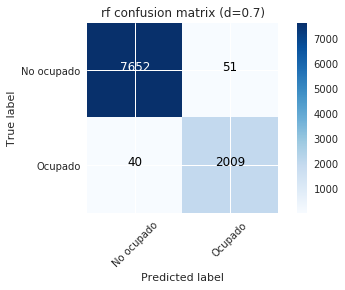

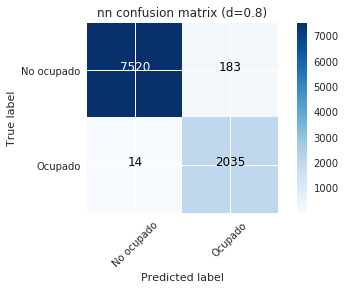

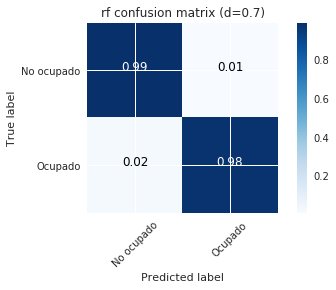

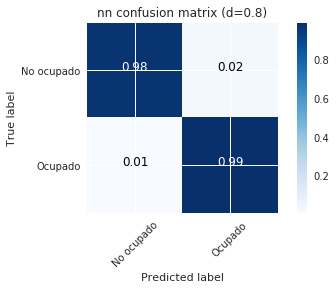

In [83]:
import itertools

n = rf_y_probas[:, 1].size
rf_d = 0.7
rf_prob = rf_y_probas[:, 1][:]
rf_class = np.zeros(n)
for i in range(n):
    if(rf_prob[i] < rf_d):
        rf_class[i] = 0
    else:
        rf_class[i] = 1

nn_d = 0.8
nn_class = np.zeros(n)
nn_prob = nn_y_probas[:, 1][:]
for i in range(n):
    if(nn_prob[i] < nn_d):
        nn_class[i] = 0
    else:
        nn_class[i] = 1
        
rf_mat = confusion_matrix(y_prueba[:, 1], rf_class)
nn_mat = confusion_matrix(y_prueba[:, 1], nn_class)


# Se define una función para graficar la matriz de confusión
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



# Se grafica la matriz de confusión
class_names = ['No ocupado', 'Ocupado']
plt.figure()
plot_confusion_matrix(rf_mat, classes=class_names,
                      title='rf confusion matrix (d=0.7)')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(nn_mat, classes=class_names,
                      title='nn confusion matrix (d=0.8)')
plt.figure()
plot_confusion_matrix(rf_mat, classes=class_names, normalize = True,
                      title='rf confusion matrix (d=0.7)')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(nn_mat, classes=class_names, normalize = True,
                      title='nn confusion matrix (d=0.8)')

plt.show()

In [105]:
# El primer punto a notar es que cada modelo usó un punto de corte diferente para tratar de minimizar la taza de falsos.
# Con las matrices de confusión se observa que ningún modelo es absolutamente mejor que otro. Esto es,
# El modelo de bosques tiene una menor tasa de falsos positivos en comparación al de redes neuronales.
# Pero el modelo de redes neuronales tiene una menor tasa de falsos negativos en comparación al de bosques aleatorios.
# Se proceden a realizar los cálculos directos para determinar dichos valores.

from sklearn.metrics import classification_report
print("rf")
print(classification_report(y_prueba[:, 1], rf_class, target_names = class_names))


print("nn")
print(classification_report(y_prueba[:, 1], nn_class, target_names = class_names))
print("\n")

print("Tasa de falsos positivos rf", rf_mat[0,1]/sum(rf_mat[0]))
print("Tasa de falsos positivos nn", nn_mat[0,1]/sum(nn_mat[0]))
print("\n")

print("Tasa de falsos negativos rf", rf_mat[1,0]/sum(rf_mat[1]))
print("Tasa de falsos negativos nn", nn_mat[1,0]/sum(nn_mat[1]))
print("\n")

print("Tasa de clasificación incorrecta rf", 
      (rf_mat[0,1]+ rf_mat[1,0])/sum(sum(rf_mat)))
print("Tasa de clasificación incorrecta nn",
      (nn_mat[0,1] + nn_mat[1,0])/sum(sum(nn_mat)))
print("\n")

print("Especificidad rf", rf_mat[0,0]/sum(rf_mat[0]))
print("Especificidad nn", nn_mat[0,0]/sum(nn_mat[0]))

print("\n")
print("Como se mencionaba previamente, el modelo de bosques aleatorios se")
print("desempeña mejor en tener una menor tasa de falsos positivos, tasa de")
print("clasificación incorrecta y una mayor especificidad.")
print("Mientras que el modelo de redes tiene un mejor desempeño al momento de")
print("minimizar la tasa de falsos negativos.")

print("Sería necesario conocer a detalle el objetivo del negocio al momento de ")
print("clasificar si la habitación está ocupada o no.")
print("Si el negocio quisiera enfocarse en un dispositivo que realice cierta acción")
print("según este o no ocupada la habitación y quiere reducir los errores del")
print("dispositivo el modelo de bosques aleatorios es una mejor opción")

print("Pero si el negocio necesita reducir los errores asociados a un falso negativo")
print("e.g. el dispositivo manda 'insecticida' a la habitación cuando no está ")
print("ocupada y dicho insecticida es molesto para los humanos/mascotas, entonces")
print("tendría sentido disminuir esos errores sin preocuparse tanto si rocie el")
print("insecticida cuando no está ocupada. Entonces el modelo de redes neuronales") 
print("tiene un mejor desempeño en este caso.")

rf
             precision    recall  f1-score   support

 No ocupado       0.99      0.99      0.99      7703
    Ocupado       0.98      0.98      0.98      2049

avg / total       0.99      0.99      0.99      9752

nn
             precision    recall  f1-score   support

 No ocupado       1.00      0.98      0.99      7703
    Ocupado       0.92      0.99      0.95      2049

avg / total       0.98      0.98      0.98      9752



Tasa de falsos positivos rf 0.00662079709204
Tasa de falsos positivos nn 0.0237569778009


Tasa de falsos negativos rf 0.0195217179112
Tasa de falsos negativos nn 0.00683260126891


Tasa de clasificación incorrecta rf 0.00933141919606
Tasa de clasificación incorrecta nn 0.0202009844135


Especificidad rf 0.993379202908
Especificidad nn 0.976243022199


Como se mencionaba previamente, el modelo de bosques aleatorios se
desempeña mejor en tener una menor tasa de falsos positivos, tasa de
clasificación incorrecta y una mayor especificidad.
Mientras que el mod